In [172]:
from binance.client import Client
import pandas as pd
import numpy as np
import pytz
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from datetime import datetime, timedelta
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [150]:
API_KEY = 'your_api_key'
API_SECRET = 'your_api_secret'

client = Client(API_KEY, API_SECRET)

client = Client()  # initialize Binance client
riyadh = pytz.timezone("Asia/Riyadh")

In [151]:
# Function to fetch full 1-hour data from Binance
def get_full_1h_data(symbol="BTCUSDT", start_str="1 Jan 2015", end_time=None):
    # If end_time is not passed, use current time
    if end_time is None:
        end_time = datetime.now(riyadh)

    start_ts = int(pd.to_datetime(start_str).timestamp() * 1000)  # Convert start date to timestamp in ms
    data = []

    print("Fetching data... This may take a while ⏳")

    while True:
        # Fetch data in 1000-candle chunks for 1-hour interval
        candles = client.get_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1HOUR,
                                    startTime=start_ts, limit=1000)
        if not candles:
            break

        df = pd.DataFrame(candles, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore'
        ])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)  # Convert from ms
        df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Riyadh')  # Convert to Riyadh timezone
        df.set_index('timestamp', inplace=True)
        df = df.astype(float)
        data.append(df[['open', 'high', 'low', 'close', 'volume']])

        # Update the start timestamp for the next loop to continue fetching data
        start_ts = int((df.index[-1] + timedelta(hours=1)).timestamp() * 1000)

        # Break the loop if we've reached the end_time
        if df.index[-1] >= end_time:
            break

        time.sleep(0.3)  # Be respectful of Binance API rate limits

    all_data = pd.concat(data)
    all_data = all_data[~all_data.index.duplicated(keep='first')]  # Remove duplicate timestamps
    return all_data

# Function to add technical indicators to the data
def add_technical_indicators(df):
    # MACD (12, 26, 9)
    macd = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()

    # RSI (14)
    rsi = RSIIndicator(close=df['close'], window=14)
    df['rsi'] = rsi.rsi()

    # Stochastic Oscillator (14, 1, 3)
    stoch = StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # Moving Averages
    df['ma_9'] = SMAIndicator(close=df['close'], window=9).sma_indicator()
    df['ma_50'] = SMAIndicator(close=df['close'], window=50).sma_indicator()
    df['ma_100'] = SMAIndicator(close=df['close'], window=100).sma_indicator()
    df['ma_200'] = SMAIndicator(close=df['close'], window=200).sma_indicator()

    # Bollinger Bands (20-period, 2 std)
    bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_middle'] = bb.bollinger_mavg()
    df['bb_width'] = bb.bollinger_wband()

    return df

In [152]:
# Example usage:
symbol = "BTCUSDT"
start_str = "1 Jan 2015"
df = get_full_1h_data(symbol=symbol, start_str=start_str, end_time=datetime.now(riyadh))

Fetching data... This may take a while ⏳


In [154]:
df = add_technical_indicators(df)

In [156]:
# Remove rows with any missing values
df.dropna(inplace=True)

In [257]:
features = ['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 
            'macd_diff', 'rsi', 'stoch_k', 'stoch_d', 'ma_9', 'ma_50', 'ma_100', 
            'ma_200', 'bb_upper', 'bb_lower', 'bb_middle', 'bb_width']

In [263]:
df.tail(1).index

DatetimeIndex(['2025-04-19 18:00:00+03:00'], dtype='datetime64[ns, Asia/Riyadh]', name='timestamp', freq=None)

In [157]:
# Select the features you want to normalize
features = ['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 
            'macd_diff', 'rsi', 'stoch_k', 'stoch_d', 'ma_9', 'ma_50', 'ma_100', 
            'ma_200', 'bb_upper', 'bb_lower', 'bb_middle', 'bb_width']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the selected features
df[features] = scaler.fit_transform(df[features])

In [158]:
def create_sequences(df, time_steps, forecast_horizon):
    """
    Creates sequences for LSTM. 
    :param df: DataFrame with historical data.
    :param time_steps: Number of past time steps to use for prediction.
    :param forecast_horizon: Number of time steps to predict (e.g., 5, 15, 30 minutes, etc.).
    :return: X, y arrays for LSTM.
    """
    X = []
    y = []
    
    # Selecting columns excluding 'close' for features in X
    feature_columns = [col for col in df.columns if col != 'close']
    
    # Adjust the range to ensure X and y are properly aligned with df
    for i in range(time_steps, len(df) - forecast_horizon + 1):  # Correct range
        # Generate the sequence for the input features (X)
        X.append(df.iloc[i - time_steps + 1:i+1][feature_columns].values)
        # Target value (y) is the value of 'close' at the forecasted time step
        y.append(df.iloc[i + forecast_horizon - 1]['close'])

    
    return np.array(X), np.array(y)


In [248]:
time_steps = 24  # Using the last 6 hourly data points (6 hours of data)
forecast_horizon = 1  # Forecast for the next hour

# Create sequences for this forecast horizon
X, y = create_sequences(df, time_steps, forecast_horizon)

# Validate the output by checking the shape of X and y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (66909, 24, 18)
y shape: (66909,)


In [249]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (53527, 24, 18)
X_test shape: (13382, 24, 18)
y_train shape: (53527,)
y_test shape: (13382,)


In [250]:
import random
import tensorflow as tf

# Set random seeds for reproducibility
def set_random_seed(seed=42):
    np.random.seed(seed)  # For numpy
    random.seed(seed)  # For python's random module
    tf.random.set_seed(seed)  # For TensorFlow

set_random_seed(42)  # You can change the seed to any integer

# Build the LSTM model
model = Sequential()

# Add LSTM layer (units = 50, input shape based on X_train)
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a dropout layer to prevent overfitting
# Add dropout layer with higher rate
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=1))  # Single unit for regression (predicting a single value)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 50)             │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,851 (54.11 KB)

 Trainable params: 13,851 (54.11 KB)

 Non-trainable params: 0 (0.00 B)

In [251]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 2/5
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.7285e-04 - val_loss: 0.0012
Epoch 3/5
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.9553e-04 - val_loss: 0.0011
Epoch 4/5
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.7349e-04 - val_loss: 3.1788e-04
Epoch 5/5
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.5021e-04 - val_loss: 4.1368e-04


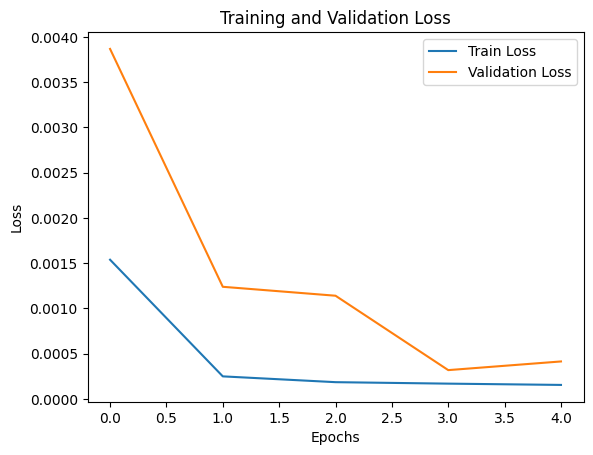

In [252]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [253]:
last_time_steps = X_test[-1:].reshape(1, X_test.shape[1], X_test.shape[2])
next_prediction = model.predict(last_time_steps)
next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


array([[0.7727362]], dtype=float32)

In [254]:
df['close'].tail(6) , next_prediction

(timestamp
 2025-04-19 13:00:00+03:00    0.781122
 2025-04-19 14:00:00+03:00    0.780812
 2025-04-19 15:00:00+03:00    0.781553
 2025-04-19 16:00:00+03:00    0.783233
 2025-04-19 17:00:00+03:00    0.782688
 2025-04-19 18:00:00+03:00    0.784712
 Name: close, dtype: float64,
 array([[0.7727362]], dtype=float32))

In [255]:
# The prediction is a scaled value of 'close'
predicted_scaled_close = next_prediction[0][0]

# To reverse the scaling, we need to reshape the prediction for the inverse transform
# We are only interested in the 'close' feature, so we reverse the scaling of just that feature
# Reverse scaling (since the scaler was fitted on all features)
predicted_close_original = scaler.inverse_transform(
    np.array([[predicted_scaled_close] + [0]*(len(features)-1)]))  # Add 0's for other features

# Print the original predicted close value (unscaled)
print(f"Predicted 'close' value (original scale): {predicted_close_original[0][0]}")

Predicted 'close' value (original scale): 84355.23595741988


In [ ]:
# Calculate the delta between the predicted and actual values in the test set
delta = (y_test - predictions).mean()

,open,high,low,close,volume,macd,macd_signal,macd_diff,rsi,stoch_k,stoch_d,ma_9,ma_50,ma_100,ma_200,bb_upper,bb_lower,bb_middle,bb_width
timestamp,,,,,,,,,,,,,,,,,,,
2025-04-19 18:00:00+03:00,0.782787,0.775783,0.785949,0.784712,0.007757,0.544017,0.551633,0.548159,0.719096,0.958237,0.955895,0.785677,0.793564,0.802093,0.801524,0.7666,0.78945,0.788602,0.027621


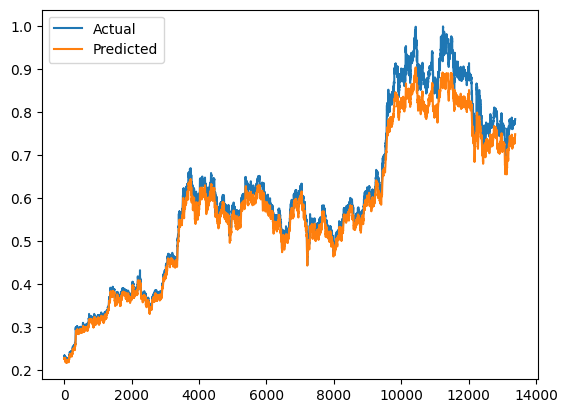

In [217]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [264]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the delta (difference) between actual and predicted values
delta = np.abs(y_test - y_pred.flatten())

# Calculate the mean delta
mean_delta = np.mean(delta)

# Print the mean delta
print(f"Mean delta between actual and predicted values: {mean_delta}")

419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean delta between actual and predicted values: 0.01358243015517592


In [265]:
# Calculate the delta (difference) between actual and predicted values
delta = np.abs(y_test - y_pred.flatten())

# Reverse the scaling for the mean delta
# Reshape the mean delta to match the scaler's expected input
mean_delta_scaled = np.mean(delta)
mean_delta_original = scaler.inverse_transform(
    np.array([[mean_delta_scaled] + [0] * (len(features) - 1)])
)[0][0]  # Extract the unscaled value for the 'close' feature

# Print the original mean delta (unscaled)
print(f"Mean delta between actual and predicted values (original scale): {mean_delta_original}")

Mean delta between actual and predicted values (original scale): 4303.155035676162
